In [42]:
!pip install fastai
!pip install tensorboard
!pip install mediapipe

                                              0.0/50.8 MB ? eta -:--:--
                                              0.1/50.8 MB 2.3 MB/s eta 0:00:22
                                              0.4/50.8 MB 4.5 MB/s eta 0:00:12
                                              0.8/50.8 MB 6.7 MB/s eta 0:00:08
                                              1.1/50.8 MB 6.6 MB/s eta 0:00:08
     -                                        1.6/50.8 MB 7.9 MB/s eta 0:00:07
     -                                        2.1/50.8 MB 8.4 MB/s eta 0:00:06
     -                                        2.5/50.8 MB 8.4 MB/s eta 0:00:06
     --                                       3.3/50.8 MB 9.6 MB/s eta 0:00:05
     ---                                      3.9/50.8 MB 10.0 MB/s eta 0:00:05
     ---                                      4.7/50.8 MB 10.6 MB/s eta 0:00:05
     ----                                     5.2/50.8 MB 10.6 MB/s eta 0:00:05
     ----                                     5.7/50.8 M

ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\Operator\\anaconda3\\Lib\\site-packages\\google\\~upb\\_message.pyd'
Consider using the `--user` option or check the permissions.



In [88]:
!pip install tensorboard

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34
import pytorch_lightning as pl
from sklearn.metrics import fbeta_score
from pytorch_lightning.callbacks.progress import TQDMProgressBar
import torch.nn.functional as F
from fastai.vision.all import *
import gc
import mediapipe as mp
import cv2

In [18]:
train_attr = "Category and Attribute Prediction Benchmark\\Anno_fine\\train_attr.txt"
test_attr = "Category and Attribute Prediction Benchmark\\Anno_fine\\test_attr.txt"
train_img = "Category and Attribute Prediction Benchmark\\Anno_fine\\train.txt"
test_img = "Category and Attribute Prediction Benchmark\\Anno_fine\\test.txt"
train_bbox = "Category and Attribute Prediction Benchmark\\Anno_fine\\train_bbox.txt"
test_bbox = "Category and Attribute Prediction Benchmark\\Anno_fine\\test_bbox.txt"

In [82]:
attributes = ['floral', 'graphic', 'striped', 'embroidered', 'solid', 'lattice',
       'long_sleeve', 'short_sleeve', 'sleeveless', 'maxi_length',
       'mini_length', 'crew_neckline', 'v_neckline', 'square_neckline',
       'no_neckline', 'denim', 'tight', 'loose', 'conventional']

In [83]:
len(attributes)

19

In [20]:
train_img = pd.read_csv(train_img, header=None, names=['image_path'], delimiter=' ', index_col=False)
test_img = pd.read_csv(test_img, header=None, names=['image_path'], delimiter=' ', index_col=False)
train_attr = pd.read_csv(train_attr, header=None, delimiter=' ', names = attributes, index_col=False)
test_attr = pd.read_csv(test_attr, header=None, delimiter=' ', names = attributes, index_col=False)
train_bbox = pd.read_csv(train_bbox, header=None, delimiter=' ', names = ['x1', 'y1', 'x2', 'y2'], index_col=False)
test_bbox = pd.read_csv(test_bbox, header=None, delimiter=' ', names = ['x1', 'y1', 'x2', 'y2'], index_col=False)

In [21]:
for i in train_img, test_img, train_attr, test_attr, train_bbox, test_bbox:
    print(i.shape)

(14000, 1)
(4000, 1)
(14000, 26)
(4000, 26)
(14000, 4)
(4000, 4)


In [22]:
train_img.reset_index(inplace=True)
train_attr.reset_index(inplace=True)
train_bbox.reset_index(inplace=True)
test_img.reset_index(inplace=True)
test_attr.reset_index(inplace=True)
test_bbox.reset_index(inplace=True)

In [23]:
train_df = train_img.merge(train_attr, on='index').merge(train_bbox, on='index')
test_df = test_img.merge(test_attr, on='index').merge(test_bbox, on='index')

In [24]:
train_df.head()

,index,image_path,floral,graphic,striped,embroidered,pleated,solid,lattice,long_sleeve,...,leather,faux,knit,tight,loose,conventional,x1,y1,x2,y2
0,0,img/Sweet_Crochet_Blouse/img_00000070.jpg,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,66,75,241,293
1,1,img/Classic_Pencil_Skirt/img_00000010.jpg,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,65,88,132,218
2,2,img/Strapless_Diamond_Print_Dress/img_00000038.jpg,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,75,43,176,300
3,3,img/Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_00000010.jpg,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,64,1,129,273
4,4,img/Zippered_Single-Button_Blazer/img_00000078.jpg,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,1,12,257,300


In [25]:
columns_to_drop = ['pleated','no_dress', 'chiffon', 'cotton', 'leather', 'faux', 'knit']

In [26]:
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)

In [27]:
train_df.head()

,index,image_path,floral,graphic,striped,embroidered,solid,lattice,long_sleeve,short_sleeve,...,square_neckline,no_neckline,denim,tight,loose,conventional,x1,y1,x2,y2
0,0,img/Sweet_Crochet_Blouse/img_00000070.jpg,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,66,75,241,293
1,1,img/Classic_Pencil_Skirt/img_00000010.jpg,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,65,88,132,218
2,2,img/Strapless_Diamond_Print_Dress/img_00000038.jpg,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,75,43,176,300
3,3,img/Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_00000010.jpg,0,0,0,0,1,0,0,0,...,0,1,1,1,0,0,64,1,129,273
4,4,img/Zippered_Single-Button_Blazer/img_00000078.jpg,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,1,12,257,300


In [28]:
columns_to_check = test_df.columns[2:21]
columns_to_check

Index(['floral', 'graphic', 'striped', 'embroidered', 'solid', 'lattice',
       'long_sleeve', 'short_sleeve', 'sleeveless', 'maxi_length',
       'mini_length', 'crew_neckline', 'v_neckline', 'square_neckline',
       'no_neckline', 'denim', 'tight', 'loose', 'conventional'],
      dtype='object')

In [33]:
has_ones = test_df[columns_to_check].sum(axis=1) == 0

print("Остались строки без единиц:")
print(test_df[has_ones])

Остались строки без единиц:
Empty DataFrame
Columns: [index, image_path, floral, graphic, striped, embroidered, solid, lattice, long_sleeve, short_sleeve, sleeveless, maxi_length, mini_length, crew_neckline, v_neckline, square_neckline, no_neckline, denim, tight, loose, conventional, x1, y1, x2, y2]
Index: []

[0 rows x 25 columns]


In [40]:
average_sum = train_df.iloc[:, 2:21].sum(axis=1)

print("Средняя сумма в каждой строке в столбцах:")
print(average_sum.mean())

Средняя сумма в каждой строке в столбцах:
4.334357142857143


In [48]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

In [76]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Обновление пользовательского датасета с применением аугментаций к изображениям
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(image_path)
        x1, y1 = (train_df.iloc[idx][-4], train_df.iloc[idx][-3])  # координаты левой верхней точки
        x2, y2 = (train_df.iloc[idx][-2], train_df.iloc[idx][-1])  # координаты правой нижней точки
        image = image.crop((x1, y1, x2, y2))
        if self.transform:
            image = self.transform(image)
        attributes = self.dataframe.iloc[idx, 2:21].values.astype(float)
        return image, attributes

In [77]:
dataset = CustomDataset(train_df, transform=transform)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [78]:
test_dataset = CustomDataset(test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


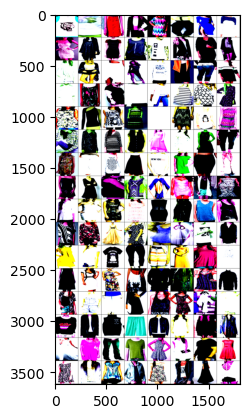

In [79]:
def imshow(img, title=None):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

data_iter = iter(train_loader)
images, _ = next(data_iter)

imshow(torchvision.utils.make_grid(images))

In [84]:
train_loss_mean = []
train_acc_mean = []
val_loss_mean = []
val_accuracy_mean = []
val_k_acc = []

In [80]:
class LabelSmoothingBCEWithLogitsLossFlat(BCEWithLogitsLossFlat):
    def __init__(self, eps:float=0.1, **kwargs):
        self.eps = eps
        super().__init__(thresh=0.2, **kwargs)

    def __call__(self, inp, targ, **kwargs):
        # https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/166833#929222
        targ_smooth = targ.float() * (1. - self.eps) + 0.5 * self.eps
        return super().__call__(inp, targ_smooth, **kwargs)

In [85]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=19):
        super(CustomResNet, self).__init__()
        resnet = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        for param in resnet.parameters():
            param.requires_grad = False
        in_features = resnet.fc.in_features
        resnet.fc = nn.Linear(in_features, num_classes)
        self.resnet = resnet

    def forward(self, x):
        return self.resnet(x)

# Определение PyTorch Lightning модели
class CustomModel(pl.LightningModule):
    def __init__(self, model, threshold = 0.7, k = 4):
        super(CustomModel, self).__init__()
        self.model = model
        self.train_loss_mean = []
        self.train_acc_mean = []
        self.train_k_acc = []
        self.val_loss_mean = []
        self.val_acc_mean = []
        self.val_k_acc = []
        self.k = k
        self.threshold = threshold

    def adversarial_loss(self, y_hat, y):
        loss_fn = LabelSmoothingBCEWithLogitsLossFlat()
        return loss_fn(y_hat, y)
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, attributes = batch
        outputs = self(images)
        loss = self.adversarial_loss(outputs, attributes)
        self.train_loss_mean.append(loss)
        accuracy = self.calculate_accuracy(outputs, attributes)
        k_acc = self.top_k_accuracy(outputs, attributes)
        self.train_acc_mean.append(accuracy)
        self.train_k_acc.append(k_acc)
        print(batch_idx, loss.item(), accuracy, k_acc)
        return loss

    def validation_step(self, batch, batch_idx):
        images, attributes = batch
        outputs = self(images)
        loss = self.adversarial_loss(outputs, attributes)
        self.val_loss_mean.append(loss)
        accuracy = self.calculate_accuracy(outputs, attributes)
        k_acc = self.top_k_accuracy(outputs, attributes)
        self.val_acc_mean.append(accuracy)
        self.val_k_acc.append(k_acc)
        return {"val_loss": loss, "val_accuracy": accuracy, "val_k_acc": k_acc}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.001)
        
    def on_validation_epoch_end(self):
        print('val epoch end')
        loss = sum(self.val_loss_mean)/len(self.val_loss_mean)
        self.val_loss_mean = []
        acc = sum(self.val_acc_mean)/len(self.val_acc_mean)
        self.val_acc_mean = []
        k_acc = sum(self.val_k_acc)/len(self.val_k_acc)
        self.val_k_acc = []
        self.log("val epoch end loss",loss, prog_bar=True)
        self.log("val epoch end acc",acc, prog_bar=True)
        self.log("val epoch end k acc",k_acc, prog_bar=True)

    def calculate_accuracy(self, outputs, targets):
        probs = F.softmax(outputs, dim=1)
        binary_mask = (probs >= self.threshold).float()
        accuracy = fbeta_score(binary_mask, targets, beta=2, average='samples')
        return accuracy

    def on_train_epoch_end(self):
        loss = sum(self.train_loss_mean)/len(self.train_loss_mean)
        self.train_loss_mean = []
        acc = sum(self.train_acc_mean)/len(self.train_acc_mean)
        self.train_acc_mean = []
        k_acc = sum(self.train_k_acc)/len(self.train_k_acc)
        self.train_k_acc = []
        self.log("train epoch end loss",loss, prog_bar=True)
        self.log("train epoch end acc",acc, prog_bar=True)
        self.log("train epoch end k acc",k_acc, prog_bar=True)
    
    def top_k_accuracy(self, outputs, targets):
        topk_values, topk_indices = torch.topk(outputs, self.k, dim=1)
        correct_count = 0
        for i in range(topk_indices.size(0)):
            for j in range(topk_indices.size(1)):
                if targets[i, topk_indices[i, j]] == 1:
                    correct_count += 1
        accuracy = correct_count / (outputs.size(0)*self.k)
        return accuracy


# Инициализация модели и тренировка
model = CustomResNet()
custom_model = CustomModel(model)
trainer = pl.Trainer(
    accelerator="auto", 
    max_epochs= 10,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
)
trainer.fit(custom_model, train_loader, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params
---------------------------------------
0 | model | CustomResNet | 21.3 M
---------------------------------------
9.7 K     Trainable params
21.3 M    Non-trainable params
21.3 M    Total params
85.178    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

val epoch end


Training: 0it [00:00, ?it/s]

0 0.7998913526535034 0.0 0.248046875
1 0.6734155416488647 0.0 0.33984375
2 0.5896674990653992 0.0 0.435546875
3 0.5325070023536682 0.0 0.505859375
4 0.5166551470756531 0.0048828125 0.55078125
5 0.5001136660575867 0.0 0.55859375
6 0.514143705368042 0.0 0.5546875
7 0.5001442432403564 0.0 0.580078125
8 0.5015832781791687 0.009765625 0.607421875
9 0.5309351086616516 0.008680555555555556 0.5625
10 0.5003957152366638 0.0048828125 0.58203125
11 0.5102464556694031 0.004340277777777778 0.57421875
12 0.5241752862930298 0.009223090277777778 0.57421875
13 0.5048778057098389 0.03255208333333333 0.611328125
14 0.5059816837310791 0.023328993055555556 0.595703125
15 0.5029503107070923 0.0146484375 0.58203125
16 0.4960118234157562 0.0048828125 0.6015625
17 0.5058189034461975 0.009765625 0.6015625
18 0.49762725830078125 0.0 0.611328125
19 0.4805969297885895 0.0 0.630859375
20 0.490931898355484 0.0 0.599609375
21 0.48274269700050354 0.0 0.634765625
22 0.4843633472919464 0.004340277777777778 0.626953125
2

Validation: 0it [00:00, ?it/s]

val epoch end
0 0.41362622380256653 0.0048828125 0.732421875
1 0.40932053327560425 0.018446180555555556 0.712890625
2 0.39771872758865356 0.013563368055555556 0.744140625
3 0.4015166461467743 0.0 0.728515625
4 0.41196852922439575 0.0 0.732421875
5 0.4109725058078766 0.0048828125 0.7109375
6 0.4020315110683441 0.0048828125 0.75390625
7 0.40213027596473694 0.009765625 0.734375
8 0.3979049623012543 0.009223090277777778 0.73046875
9 0.4100988209247589 0.0146484375 0.736328125
10 0.41162049770355225 0.0 0.705078125
11 0.3987937867641449 0.009223090277777778 0.740234375
12 0.4139811396598816 0.0048828125 0.70703125
13 0.395319402217865 0.009765625 0.755859375
14 0.40727683901786804 0.004340277777777778 0.71875
15 0.4161933362483978 0.0146484375 0.7265625
16 0.41614457964897156 0.009765625 0.685546875
17 0.399064302444458 0.0146484375 0.736328125
18 0.39073172211647034 0.009223090277777778 0.75390625
19 0.3903930187225342 0.0048828125 0.771484375
20 0.3989886939525604 0.008680555555555556 0.7

Validation: 0it [00:00, ?it/s]

val epoch end
0 0.3820051848888397 0.0146484375 0.7578125
1 0.39470839500427246 0.013563368055555556 0.744140625
2 0.3890526294708252 0.0 0.759765625
3 0.3716813027858734 0.009765625 0.78515625
4 0.3990509510040283 0.0048828125 0.71875
5 0.3746732175350189 0.0048828125 0.802734375
6 0.38816598057746887 0.0 0.751953125
7 0.38257527351379395 0.014105902777777778 0.75390625
8 0.3940592408180237 0.009765625 0.765625
9 0.3851829171180725 0.009223090277777778 0.76171875
10 0.3947620987892151 0.009223090277777778 0.740234375
11 0.3948940336704254 0.0146484375 0.734375
12 0.3885021507740021 0.009223090277777778 0.7421875
13 0.3781828284263611 0.013563368055555556 0.77734375
14 0.39907920360565186 0.023871527777777776 0.732421875
15 0.39819613099098206 0.023328993055555556 0.716796875
16 0.37919294834136963 0.0048828125 0.771484375
17 0.3844418227672577 0.009765625 0.771484375
18 0.3842061161994934 0.0 0.76171875
19 0.3734488785266876 0.005580357142857143 0.771484375
20 0.36621174216270447 0.01

Validation: 0it [00:00, ?it/s]

val epoch end
0 0.39933261275291443 0.014105902777777778 0.72265625
1 0.37599101662635803 0.01953125 0.771484375
2 0.37860578298568726 0.0048828125 0.767578125
3 0.38368332386016846 0.009765625 0.76171875
4 0.3896180987358093 0.009223090277777778 0.763671875
5 0.38685134053230286 0.004340277777777778 0.759765625
6 0.3716230094432831 0.0 0.791015625
7 0.37903520464897156 0.0244140625 0.75390625
8 0.3845614194869995 0.0146484375 0.76953125
9 0.3795035779476166 0.009765625 0.7578125
10 0.37476983666419983 0.0 0.7734375
11 0.3727394938468933 0.009223090277777778 0.767578125
12 0.3886910378932953 0.0048828125 0.75390625
13 0.3807770609855652 0.018988715277777776 0.77734375
14 0.37432727217674255 0.0146484375 0.775390625
15 0.36972662806510925 0.022786458333333336 0.787109375
16 0.38566502928733826 0.015345982142857144 0.759765625
17 0.38213250041007996 0.022786458333333336 0.78125
18 0.39319679141044617 0.014105902777777778 0.736328125
19 0.372067928314209 0.009765625 0.76953125
20 0.367510

Validation: 0it [00:00, ?it/s]

val epoch end
0 0.38346627354621887 0.04774305555555555 0.748046875
1 0.37469780445098877 0.0 0.78125
2 0.3961659371852875 0.004340277777777778 0.740234375
3 0.37872397899627686 0.008680555555555556 0.765625
4 0.3689285218715668 0.014105902777777778 0.80078125
5 0.358443945646286 0.029296875 0.796875
6 0.3931316137313843 0.009765625 0.75390625
7 0.36908191442489624 0.0048828125 0.77734375
8 0.36932554841041565 0.014105902777777778 0.76953125
9 0.37131842970848083 0.027669270833333336 0.791015625
10 0.37875309586524963 0.018446180555555556 0.76171875
11 0.3733483552932739 0.033637152777777776 0.775390625
12 0.378785103559494 0.033637152777777776 0.775390625
13 0.3739016652107239 0.03704737103174603 0.76953125
14 0.3841777741909027 0.018988715277777776 0.74609375
15 0.37608209252357483 0.0048828125 0.771484375
16 0.37904539704322815 0.023328993055555552 0.767578125
17 0.38261809945106506 0.018988715277777776 0.759765625
18 0.3834491968154907 0.014105902777777778 0.755859375
19 0.36947593

Validation: 0it [00:00, ?it/s]

val epoch end
0 0.37549763917922974 0.0146484375 0.791015625
1 0.38751646876335144 0.014105902777777778 0.7421875
2 0.3769191801548004 0.018446180555555556 0.7734375
3 0.36915552616119385 0.017903645833333336 0.794921875
4 0.38563910126686096 0.014105902777777778 0.7578125
5 0.37312114238739014 0.013563368055555556 0.78125
6 0.37977543473243713 0.0146484375 0.748046875
7 0.37199750542640686 0.014105902777777778 0.783203125
8 0.371249794960022 0.029296875 0.779296875
9 0.37390172481536865 0.023871527777777776 0.759765625
10 0.37467682361602783 0.018012152777777776 0.779296875
11 0.3838208317756653 0.009223090277777778 0.755859375
12 0.39168915152549744 0.022786458333333336 0.748046875
13 0.37563857436180115 0.0048828125 0.77734375
14 0.3658517599105835 0.0048828125 0.78515625
15 0.3691484034061432 0.01953125 0.76953125
16 0.36460575461387634 0.03797743055555555 0.79296875
17 0.3732273280620575 0.0244140625 0.7890625
18 0.385429710149765 0.018446180555555556 0.748046875
19 0.377481907606

Validation: 0it [00:00, ?it/s]

val epoch end
0 0.3612922132015228 0.014105902777777778 0.82421875
1 0.3673498332500458 0.0185546875 0.779296875
2 0.37395477294921875 0.0244140625 0.78515625
3 0.38587328791618347 0.009223090277777778 0.755859375
4 0.3731803297996521 0.032552083333333336 0.755859375
5 0.37960219383239746 0.023328993055555552 0.76171875
6 0.38135194778442383 0.046115451388888895 0.794921875
7 0.37858879566192627 0.022786458333333336 0.771484375
8 0.38489603996276855 0.013020833333333334 0.755859375
9 0.36276957392692566 0.023328993055555556 0.791015625
10 0.3814680576324463 0.0146484375 0.767578125
11 0.3692910373210907 0.0 0.794921875
12 0.36060386896133423 0.0048828125 0.8125
13 0.3704485297203064 0.009765625 0.7890625
14 0.37474796175956726 0.0244140625 0.771484375
15 0.39840394258499146 0.0048828125 0.728515625
16 0.36290672421455383 0.027777777777777776 0.8125
17 0.3822856843471527 0.014105902777777778 0.775390625
18 0.38911497592926025 0.022352430555555556 0.759765625
19 0.3740703761577606 0.0287

Validation: 0it [00:00, ?it/s]

val epoch end
0 0.3706247806549072 0.0341796875 0.77734375
1 0.3874339163303375 0.022243923611111112 0.755859375
2 0.3854798972606659 0.018446180555555556 0.744140625
3 0.3900153934955597 0.023871527777777776 0.740234375
4 0.3742111623287201 0.033637152777777776 0.7734375
5 0.3710056245326996 0.03309461805555555 0.767578125
6 0.3801727294921875 0.018446180555555556 0.759765625
7 0.35573092103004456 0.0 0.791015625
8 0.37652119994163513 0.014105902777777778 0.78125
9 0.3518555760383606 0.03200954861111111 0.81640625
10 0.3741927742958069 0.023871527777777776 0.783203125
11 0.3731936812400818 0.0146484375 0.78515625
12 0.3710479140281677 0.013563368055555556 0.783203125
13 0.3654204308986664 0.038519965277777776 0.78515625
14 0.3772008419036865 0.018988715277777776 0.74609375
15 0.375145822763443 0.022243923611111112 0.771484375
16 0.3854959011077881 0.02945188492063492 0.744140625
17 0.36602962017059326 0.03309461805555555 0.80078125
18 0.3836996257305145 0.014105902777777778 0.76953125

Validation: 0it [00:00, ?it/s]

val epoch end
0 0.38753360509872437 0.023328993055555556 0.755859375
1 0.37905436754226685 0.022352430555555556 0.7734375
2 0.37165793776512146 0.03309461805555555 0.77734375
3 0.3552521765232086 0.014105902777777778 0.794921875
4 0.3793393075466156 0.01953125 0.7734375
5 0.37433552742004395 0.018988715277777776 0.779296875
6 0.37751129269599915 0.027669270833333336 0.7734375
7 0.35919389128685 0.055338541666666664 0.8203125
8 0.3534349501132965 0.018988715277777776 0.814453125
9 0.37041839957237244 0.044642857142857144 0.771484375
10 0.35243988037109375 0.029296875 0.80859375
11 0.3765963315963745 0.05642361111111111 0.759765625
12 0.3688671290874481 0.023328993055555556 0.783203125
13 0.3717448115348816 0.018988715277777776 0.77734375
14 0.37717196345329285 0.037434895833333336 0.763671875
15 0.3675035834312439 0.023328993055555556 0.765625
16 0.3629167079925537 0.018446180555555556 0.79296875
17 0.37260472774505615 0.018988715277777776 0.798828125
18 0.37018322944641113 0.0289093501

Validation: 0it [00:00, ?it/s]

val epoch end
0 0.3628920018672943 0.0390625 0.783203125
1 0.3763132095336914 0.048285590277777776 0.767578125
2 0.3837875425815582 0.04286024305555555 0.751953125
3 0.375204861164093 0.018988715277777776 0.779296875
4 0.35856059193611145 0.024026537698412696 0.798828125
5 0.36509087681770325 0.018988715277777776 0.80859375
6 0.35498788952827454 0.01953125 0.80859375
7 0.37156516313552856 0.018446180555555556 0.78125
8 0.37052956223487854 0.027669270833333336 0.787109375
9 0.36991646885871887 0.023871527777777776 0.78515625
10 0.3794151842594147 0.03797743055555555 0.79296875
11 0.3759704828262329 0.04231770833333333 0.765625
12 0.3819495141506195 0.03309461805555555 0.75390625
13 0.37665441632270813 0.023328993055555556 0.77734375
14 0.3828136622905731 0.023871527777777776 0.771484375
15 0.38598474860191345 0.042317708333333336 0.76953125
16 0.37344691157341003 0.028909350198412696 0.787109375
17 0.3612709045410156 0.014105902777777778 0.798828125
18 0.36056214570999146 0.038132440476

Validation: 0it [00:00, ?it/s]

val epoch end


`Trainer.fit` stopped: `max_epochs=10` reached.


In [89]:
%tensorboard --logdir lightning_logs/ 
%tensorboard --logdir lightning_logs/

UsageError: Line magic function `%tensorboard` not found.


In [90]:
from tensorboard import notebook
notebook.list()  # Покажет активные TensorBoard'ы

# Выберите нужный logdir из списка, например, 'lightning_logs'
logdir = 'lightning_logs'
notebook.start(f'--logdir {logdir}')

Known TensorBoard instances:
  - port 6006: logdir lightning_logs/ (started 5 days, 7:30:32 ago; pid 13088)
  - port 6006: logdir lightning_logs/ (started 6 days, 13:51:01 ago; pid 31300)


In [91]:
torch.save(custom_model.model.state_dict(), 'saved_model_modified.pth')

In [95]:
custom_model.model.state_dict()

OrderedDict([('resnet.conv1.weight',
              tensor([[[[ 5.4109e-03, -6.9092e-03,  7.8839e-03,  ...,  4.9072e-02,
                          3.0660e-02,  2.5398e-02],
                        [ 4.1081e-02,  3.1296e-02,  3.2265e-02,  ...,  3.3145e-02,
                          2.9754e-02,  4.1735e-02],
                        [ 4.9519e-03, -3.1705e-02, -6.1310e-02,  ..., -9.7493e-02,
                         -1.1601e-01, -1.2191e-01],
                        ...,
                        [-1.2287e-02, -2.4841e-02, -9.3052e-03,  ...,  1.7113e-02,
                          2.4631e-03,  1.6726e-02],
                        [ 3.9117e-03,  4.4537e-03,  3.6315e-02,  ...,  1.0371e-01,
                          7.3973e-02,  5.9085e-02],
                        [ 1.6784e-02,  8.8902e-03,  3.1312e-02,  ...,  9.6964e-02,
                          8.3749e-02,  9.6970e-02]],
              
                       [[-7.7192e-03, -8.7711e-03,  1.4143e-02,  ...,  3.3901e-02,
                         

In [92]:
mod = CustomResNet()
cust_model = CustomModel(mod)
cust_model.model.load_state_dict(torch.load('saved_model_modified.pth'))

<All keys matched successfully>

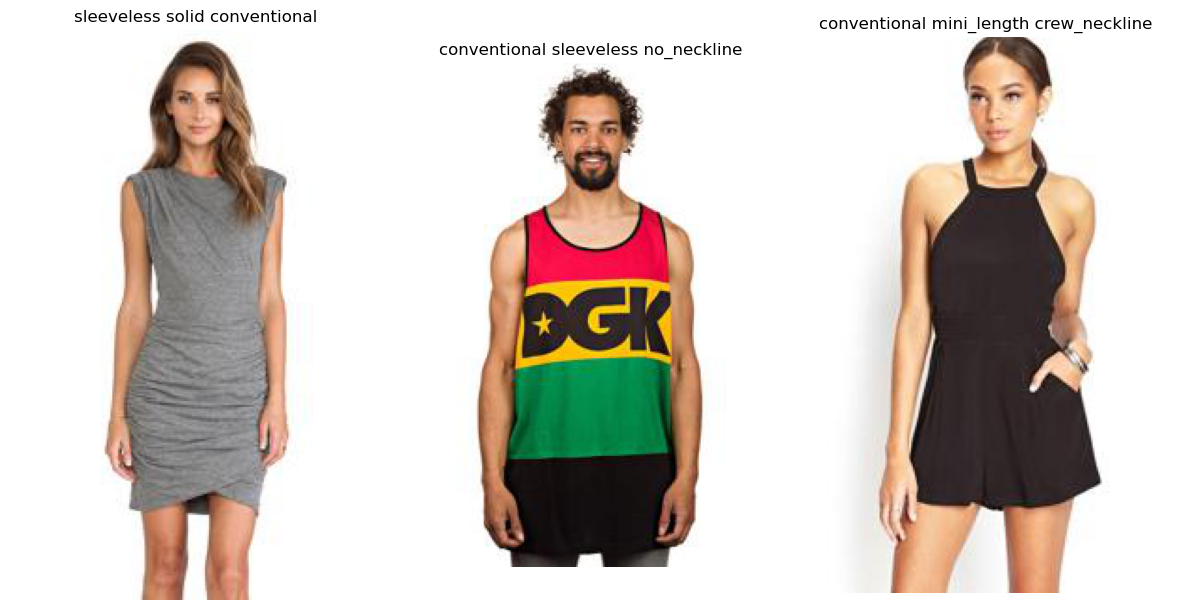

In [94]:
random_indices = random.sample(range(len(test_df)), 3)
random_test_df = test_df.loc[random_indices, ::]
dataset = CustomDataset(random_test_df, transform=transform)
random_test_loader = DataLoader(dataset, batch_size=5, shuffle=False)
attributes = test_df.columns[2:28]
for batch_idx, (inputs, targets) in enumerate(random_test_loader):
    with torch.no_grad():
        outputs = cust_model(inputs)
    topk_values, topk_indices = torch.topk(outputs, 3, dim=1)
    images = [Image.open(image_path) for image_path in random_test_df.image_path]
    captions = []
    for i in range(topk_indices.size(0)):
        label = ""
        for j in range(topk_indices.size(1)):
            label += f'{attributes[topk_indices[i, j].item()]} '
        captions.append(label)
        
    plt.figure(figsize=(12, 6))
    for i, (image, label) in enumerate(zip(images, captions)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(label, fontsize=12)

    plt.tight_layout()
    plt.show()